In [ ]:
# Install CudaQ package
!pip install cudaq

from IPython.display import clear_output
clear_output()

In [1]:
import cudaq

In [2]:
import numpy as np
import scipy as sp
from numpy import linalg as LA
from copy import deepcopy
from numpy import matmul
import math
import matplotlib.pyplot as plt
import time

In [3]:
# Check the hermitian matrix
def check_hermitian(mat):
  if np.allclose(mat, mat.T.conjugate(), rtol=1e-05, atol=1e-08):
    pass
  else:
    print("Sorry! The input matrix should be Hermitian.")

In [4]:
# Define linear system
A = 0.25*np.array([[15.,9,5,-3],[9,15,3,-5],[5.,3,15,-9],[-3.,-5,-9,15]])
b = 0.5*np.array([1,1,1,1]).T

# Normalize vector b
norm_b = LA.norm(b)
A = A / norm_b
b = b / norm_b

# Exact solution 
csol = LA.solve(A,b)
check_hermitian(A)
print("Condition number of A: ", LA.cond(A))
print("Eigenvalues of A: ", LA.eigvals(A))

Condition number of A:  8.000000000000002
Eigenvalues of A:  [8. 4. 1. 2.]


In [5]:
# Modified version of QFT available on CudaQ documentation: swaps added.
@cudaq.kernel
def QFT(qubits: cudaq.qview):
    '''Args:
    qubits (cudaq.qview): specifies the quantum register to which apply the QFT.'''
    qubit_count = len(qubits)
    # For this specific instance, following swaps should be added
    swap(qubits[1], qubits[qubit_count - 2])
    swap(qubits[0], qubits[qubit_count - 1])
    
    # Apply Hadamard gates and controlled rotation gates.
    for i in range(qubit_count):
        h(qubits[i])
        for j in range(i + 1, qubit_count):
            angle = -(2 * np.pi) / (2**(j - i + 1))
            cr1(angle, [qubits[j]], qubits[i])

# Inverse of QFT can be accessed by applying adjoint operator.
@cudaq.kernel
def invQFT(qubits: cudaq.qview):
    '''Args:
    qubits (cudaq.qview): specifies the quantum register to which apply the inverse QFT.'''
    cudaq.adjoint(QFT, qubits)

In [6]:
# Parameters
c_num = 4
b_num = int(np.log2(len(b)))

In [7]:
# Calculating the unitary matrices needed for Hamiltonian simulation 
U = {}
t = 2*np.pi
for i in range(c_num):
    Time = t/(2**(c_num - i))
    U[i] = sp.linalg.expm(-1j * A * Time)
    cudaq.register_operation(f"U{i}", U[i])
# print(U)

In [8]:
# Calculating the unitary matrices needed for inverse Hamiltonian simulation step
Uinv = {}
for i in range(c_num-1,-1,-1):
    Time = t/(2**(c_num-i))
    Uinv[i] = sp.linalg.expm(-1j * -A * Time)
    cudaq.register_operation(f"Uinv{i}", Uinv[i])
# print(Uinv)

In [9]:
# Checking if U and Uinv matrices are unitary
for i in range(len(U.keys())):
    print(f"Is U{i} unitary?    ", np.allclose(U[i] @ U[i].conj().T, np.eye(U[i].shape[0])))
    
for i in range(len(Uinv.keys())):
    print(f"Is Uinv{i} unitary? ", np.allclose(Uinv[i] @ Uinv[i].conj().T, np.eye(Uinv[i].shape[0])))

Is U0 unitary?     True
Is U1 unitary?     True
Is U2 unitary?     True
Is U3 unitary?     True
Is Uinv0 unitary?  True
Is Uinv1 unitary?  True
Is Uinv2 unitary?  True
Is Uinv3 unitary?  True


In [10]:
@cudaq.kernel

def QuantumLinearSystemSolver(b: list[float], r: int, t: float):
    """
    A: The matrix representing the linear system.
    b: The vector representing the right-hand side of the linear system.
    t: A time parameter used in the controlled-Hamiltonian operations.
    r: A parameter used to determine the rotation angles for the ancilla qubit.
    shots: The number of shots (repetitions) for the quantum circuit execution.
    """
    #==========================================================================
    # Preprocessing
    #==========================================================================
    # check_hermitian(A)

    # # Normalize A and b
    # norm_b = LA.norm(b)
    # A = A / norm_b
    # b = b / norm_b

    # # Calculate condition number and eigenvalues of A
    # kappa = LA.cond(A)
    # eigs = LA.eigvals(A)

    #==========================================================================
    # Quantum Circuit
    #==========================================================================

    # Qubits
    qAnc = cudaq.qubit()
    cReg = cudaq.qvector(c_num)
    bReg = cudaq.qvector(b)       # Giving vector b to qvector initializes the quantum state.

    # Classical bits
    cAnc = [0]
    bVec = [0 for i in range(b_num)]


    # Apply Hadamard on register C
    h(cReg)

    # Apply Hamiltonian 
    for i in range(c_num):
        if i == 0:
            U0.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 1:
            U1.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 2:
            U2.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 3:
            U3.ctrl([cReg[i]], bReg[0], bReg[1])
            
    # Apply inverse QFT
    QFT(cReg)

    # Swap the qubit
    swap(cReg[1], cReg[c_num - 1])

    # Apply y rotations on Ancilla qubit
    for i in range(c_num):
        exponent = c_num - r - i
        theta = np.pi/(2**(-exponent))
        ry.ctrl(theta, [cReg[i]], qAnc)  
        
    # # ================ Uncompute the circuit ================
    
    # Swap the qubit
    swap(cReg[1], cReg[c_num - 1])

    # Apply QFT
    invQFT(cReg)

    # Apply Hamiltonian
    for i in range(c_num-1,-1,-1):
        if i == 0:
            Uinv0.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 1:
            Uinv1.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 2:
            Uinv2.ctrl([cReg[i]], bReg[0], bReg[1])
        if i == 3:
            Uinv3.ctrl([cReg[i]], bReg[0], bReg[1])

    # Apply Hadamard on register C
    h(cReg)

    # Measurement
    mz(qAnc)
    mz(bReg)

In [11]:
# Extract approximate solution of the quantum linear solver
def approximate_quantum_sol(sol,b_num):
  num = 0
  app_sol = np.zeros(2**(b_num))

  for key, value in sol.items(): 
    if key[0] == '1':
      num += value 
      cord = int(key[-1:0:-1],base=2)
      app_sol[cord] = value
  if num == 0:
    return app_sol
  
  app_sol = 1/num *app_sol
  return app_sol

print("Please run the quantum solver.")

Please run the quantum solver.


In [12]:
r_choice = 5

In [13]:
# Do the experiment
shots = 30000
SampleResults = cudaq.sample(QuantumLinearSystemSolver, b, r_choice, 2*np.pi, shots_count= shots)

MostProbableResult = SampleResults.most_probable()
Prob = SampleResults.probability(MostProbableResult)
print("Sample Results: \n")
print(SampleResults)
print("Most probable result: " + MostProbableResult)
print("Measured with probability " + str(Prob), end='\n\n')  

qsol = np.sqrt(approximate_quantum_sol(SampleResults,b_num))

print("============================== Final results ==============================\n")
print ('Exact solution = ', csol)
print('Quantum solver solution = ', qsol)
print('Norm of difference = ', LA.norm(qsol- csol),'\n')

Sample Results: 

{ 000:11075 001:2222 010:1737 011:1122 100:606 101:3122 110:4164 111:5952 }

Most probable result: 000
Measured with probability 0.36916666666666664

============================== Final results ==============================

Exact solution =  [-0.03125  0.21875  0.34375  0.40625]
Quantum solver solution =  [0.20922112 0.54843425 0.47488194 0.65569318]
Norm of difference =  0.49591888979304133 



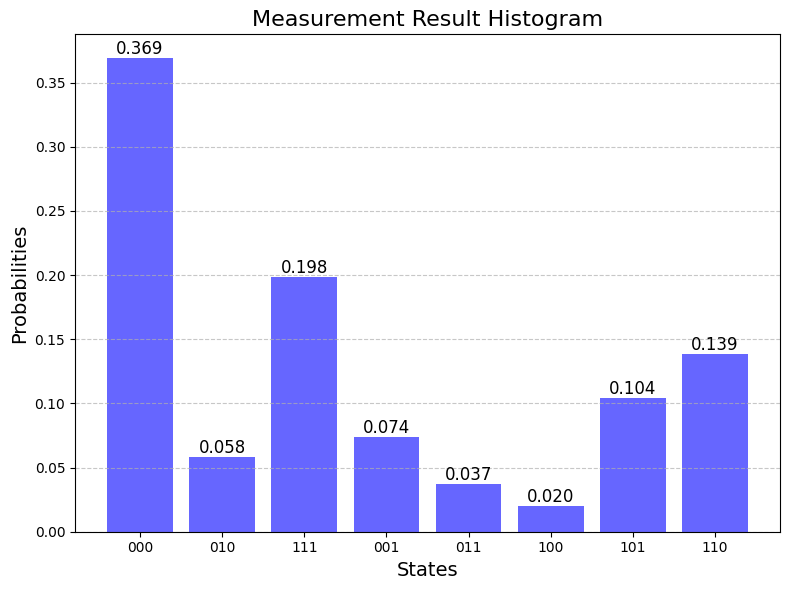

Note: In contrast to Qiskit which uses little-endian, CudaQ uses big-endian!


In [14]:
# Extract keys and values
states = []
probabilities = []
for key, value in SampleResults.items():
    states.append(key)
    probabilities.append(value/shots)

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(states, probabilities, color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('States', fontsize=14)
plt.ylabel('Probabilities', fontsize=14)
plt.title('Measurement Result Histogram', fontsize=16)

# Add bar labels
for i, prob in enumerate(probabilities):
    plt.text(i, prob, f'{prob:.3f}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Note: In contrast to Qiskit which uses little-endian, CudaQ uses big-endian!")

In [15]:
# Draw the quantum circuit
print("============================== Circuit structure ============================== \n")
print(cudaq.draw(QuantumLinearSystemSolver, b, r_choice, 2*np.pi))

============================== Circuit structure ============================== 

                                                                       »
q0 : ──────────────────────────────────────────────────────────────────»
     ╭───╮                           ╭───╮╭────────────╮╭─────────────╮»
q1 : ┤ h ├──●──────────────────────╳─┤ h ├┤ r1(-1.571) ├┤ r1(-0.7854) ├»
     ├───┤  │                      │ ╰───╯╰─────┬──────╯╰──────┬──────╯»
q2 : ┤ h ├──┼─────●───────────╳────┼────────────●──────────────┼───────»
     ├───┤  │     │           │    │                           │       »
q3 : ┤ h ├──┼─────┼─────●─────╳────┼───────────────────────────●───────»
     ├───┤  │     │     │          │                                   »
q4 : ┤ h ├──┼─────┼─────┼─────●────╳───────────────────────────────────»
     ╰───╯╭─┴──╮╭─┴──╮╭─┴──╮╭─┴──╮                                     »
q5 : ─────┤>   ├┤>   ├┤>   ├┤>   ├─────────────────────────────────────»
          │ U0 ││ U1 ││ U2 ││ U3 │        

In [16]:
import itertools
def norm_estimation (A,b,x):
    # this function finds scaling factor alpha such that alpha = argmin ||A alpha x - b||_2^2
    v= A@x
    alpha = (np.dot(v,b))/(np.dot(v,v))
    return alpha

In [17]:
precision = 1e-6
max_iter  = 10000

In [18]:
def IR(A,b,precision,max_iter):
    ### Scaled Iterative Refinement for solving a linear system
    nabla             = 1                             # Scaling factor
    rho               = 2                             # Incremental scaling
    d                 = len(A)                        # Dimension
    iteration         = 0
    x                 = np.zeros(d)                   # Solution
    r                 = b                             # Residual
    con               = np.linalg.cond(A)             # Condition number

    b0 = b
    
    r_record=[]
    # print(np.linalg.norm(r)>precision, iteration<=max_iter)
    #  and iteration<=max_iter
    while (np.linalg.norm(r)>precision and iteration<=max_iter):
        b = nabla*r
        # print('b:', b)
        
        SampleResults = cudaq.sample(QuantumLinearSystemSolver, b, r_choice, 2*np.pi, shots_count= shots)
        
        c = np.sqrt(approximate_quantum_sol(SampleResults,b_num))
        
        for idx in range(len(csol)):
            if np.sign(csol[idx]) != np.sign(c[idx]):
                c[idx] = (-1)*c[idx]
                
        if LA.norm(c) != 1:
            # print('Normalizing')
            c = c/LA.norm(c)
            
        alpha = norm_estimation(A,r*nabla,c)                # Calculating best norm estimation
        x = x + (alpha/nabla)*c                             # Updating solution
        r = b0 - np.dot(A, x)
        if LA.norm(r) == 0:
            print("Residual norm is too small, stopping iteration.")
            res = np.linalg.norm(r)
            break
        # nabla = min(rho*nabla,1/(LA.norm(r)))  # Updating scaling factor
        nabla = 1/(LA.norm(r))
        # print("Nabla", nabla)
        res = np.linalg.norm(r)
        r_record.append(res)
        iteration=iteration+1
        # print('Norm(r):', LA.norm(r))
        # print("Precision:",LA.norm((LA.norm(r) - A*c*alpha)))
    return res, x, r_record

In [19]:
start = time.time()
residual, ir_sol, convhist = IR(A,b,precision,max_iter)
end = time.time()

elapsed_time = end - start

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
milliseconds = int((elapsed_time * 1000) % 1000)

print(f"Elapsed time: {minutes:02}:{seconds:02}:{milliseconds:03}")

Elapsed time: 00:00:413


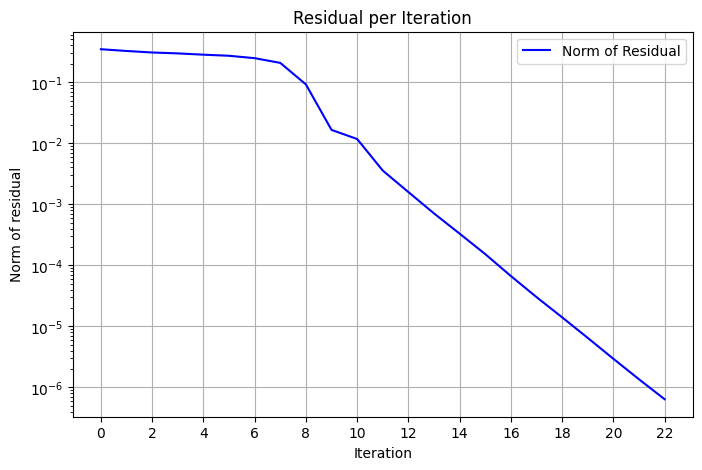

In [20]:
iterations = range(len(convhist))  # x-axis is iteration index

# Plot
plt.figure(figsize=(8, 5))
plt.plot(iterations, convhist, linestyle='-', color='b', label='Norm of Residual')
plt.xlabel('Iteration')
plt.ylabel('Norm of residual')
plt.yscale('log')
plt.xticks(range(0,len(convhist),2))
plt.title('Residual per Iteration')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
LA.norm(csol-ir_sol)

np.float64(4.6930998496842384e-07)

In [22]:
csol

array([-0.03125,  0.21875,  0.34375,  0.40625])

In [23]:
ir_sol

array([-0.03124973,  0.21874978,  0.34374981,  0.40624974])